## ldist: Local neighborhood distances

In [2]:
from ipynb.fs.full.koselleck import *

In [12]:
INDEX_LDIST=['word1','word2','corpus1','corpus2','period1','period2']

def ldist_qstr(col1,col2,k,incl_words):
    return f"{col1}/{col2}/k={k}/incl_words={incl_words}"

def ldist_word_qstr(word,ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,k=K,
                    corpus=DEFAULT_CORPUS):
    return f'{word}/{corpus}/{ymin}-{ymax}_{ybin}'

def ldist(word_or_words, all_periods=False, **ldist_iter_opts):
    l=[res for res in ldist_iter(word_or_words, **ldist_iter_opts)]
    odf=pd.concat(l) if len(l) else pd.DataFrame()
    if len(odf) and all_periods:
        odf=odf.reset_index()
        odf=odf.append(odf.assign(period1=odf.period2, period2=odf.period1))
        odf=odf.set_index(INDEX_LDIST).sort_index()
    return odf

def ldist_iter(word_or_words, force=False, num_proc=1,
               ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,k=K,
               corpus=DEFAULT_CORPUS,commit_byword=False,progress=True,cache=True,
               **ldist_word_opts):
    objs=[
        dict(word=w, force=force, progress=False, num_proc=1,# if commit_byword else num_proc,
             commit=not commit_byword, return_dict=False, qstr=ldist_word_qstr(
                w,ymin=ymin,ymax=ymax,ybin=ybin,k=k,corpus=corpus
             ), **ldist_word_opts)
        for w in to_words(word_or_words)
    ]
    
    iterr=pmap_iter(
        ldist_word_,
        objs,
        num_proc=num_proc,#1 if not commit_byword else num_proc,
        progress=progress if len(objs)>1 else False,
        kwargs=dict(ymin=ymin,ybin=ybin,ymax=ymax,k=k,commit=cache,progress=progress if len(objs)==1 else False)
    )
        #for i,dbd in enumerate(iterr):
        #    for qstr,odx in dbd.items(): db[qstr]=odx
        #    if i and not i%100: db.commit()
        #    odf=pd.DataFrame(dbd.values())
    
    if commit_byword:
        with get_db('ldist',mode='c') as db:
            for i,(obj,odf) in enumerate(zip(objs,iterr)):
                if odf is not None and len(odf):
                    db[obj['qstr']]=odf
                    yield odf
                if i and not i%10: db.commit()
            db.commit()
    else:
        yield from iterr
    
def ldist_word_(objd, **attrs):
    o={**objd, **attrs}
    return ldist_word(**o)
def ldist_word(word,
               k=K,
               incl_words=False,
               force=False,
               progress=True,
               num_proc=1,
               ybin=YBIN_DISTMAT,
               ymin=YMIN_DISTMAT,
               ymax=YMAX_DISTMAT,
               return_dict=False,
               commit=True,
               **wdist_opts):
    dfdist=wdist(word, ybin=ybin, ymin=ymin, ymax=ymax, **wdist_opts)
    l=[]
    qcols=[
        (col1,col2,ldist_qstr(col1,col2,k,incl_words))
        for col1 in dfdist.columns for col2 in dfdist.columns if col1<col2
    ]
    dbdone,dbqueue={},{}
    if force or not commit:
        ql=qcols
    else:
        with get_db('ldist',mode='r') as db:
            for q in qcols:
                if q[-1] in db:
                    dbdone[q[-1]]=db[q[-1]]
            ql=[q for q in qcols if not q[-1] in dbdone]
    
    if len(ql):
        objs = [
            (dfdist[col1],dfdist[col2],k,incl_words)
            for col1,col2,qstr in ql
        ]
        
        iterr = pmap_iter(do_ldist, objs, num_proc=num_proc, progress=progress)
        for (col1,col2,qstr),odx in zip(ql,iterr):
            odx['word1'],odx['corpus1'],odx['period1']=col1.split('_')
            odx['word2'],odx['corpus2'],odx['period2']=col2.split('_')
            dbqueue[qstr]=odx
        iterr.close()
        
        if commit:
            with get_db('ldist',mode='c') as db:
                for qstr,odx in dbqueue.items():
                    db[qstr]=odx
                db.commit()
    
    dbd={**dbdone, **dbqueue}
    if return_dict: return dbd
    odf=pd.DataFrame(dbd.values())
    if len(odf): odf=odf.set_index(INDEX_LDIST).sort_index()
    return odf
    
    
    
    
    
def do_ldist(obj):
    s1,s2,k,incl_words=obj
    s1,s2=s1.dropna(),s2.dropna()
    valid_words_now=set(s1.index) & set(s2.index)
    s1=s1.loc[valid_words_now].sort_values()
    s2=s2.loc[valid_words_now].sort_values()

    # get top words for each
    nb1=s1.iloc[:k].index
    nb2=s2.iloc[:k].index

    # get meta neighborhoods
    mnb=list(set(nb1)|set(nb2))
    nb1s=s1.loc[mnb]
    nb2s=s2.loc[mnb]

    # try to get distance
    try:
        #print(f'Computing: {col1} vs {col2}')
        distdists = 1-fastdist.cosine(nb1s.values.astype(float), nb2s.values.astype(float))
    except ZeroDivisionError as e:
        distdists=np.nan

    # return dict as df
    odx={
        'dist':distdists,
        'mneighb_size':len(mnb),
        'neighb1_size':len(nb1),
        'neighb2_size':len(nb2),
        'neighb1':', '.join(nb1) if incl_words else '',
        'neighb2':', '.join(nb2) if incl_words else '',
    }
    return odx

In [13]:
# wl=random.sample(get_valid_words(),3)
wl=get_valid_words()
for odf in ldist_iter(wl,ymin=1680,ymax=1960,num_proc=4):
    #display(odf)
    #break
    pass

Mapping ldist_word_() [x1]: 100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


In [ ]:
stop

In [4]:
# w=random.choice(get_valid_words())
# ldist(w,ybin=20,all_periods=True)

## Speed of change

In [5]:
# def speed(words):
    
def speed_word(word, ybin=YBIN_DISTMAT, **ldist_opts):
    def is_bef_aft(row):
        return row.period2.split('-')[0] == row.period1.split('-')[-1]
    
    dists=ldist(word, ybin=ybin, all_periods=True,**ldist_opts).reset_index()
    dists_wanted = dists[dists.apply(is_bef_aft,axis=1)]
    return dists_wanted
    
    groups=list(dists.groupby('period1'))
    l=[]
    for period,pdf in dists.groupby('period1'):
        for i,p2 in enumerate(sorted(pdf.period2)):
            if p2>=period: break
        period_justbefore = pdf.iloc[i-1]
        o=dict(
            **dict(period_justbefore),
        )
        l+=[o]
    return pd.DataFrame(l)

In [6]:
# dfnov=get_nov_data_summarised()
# dfnov

In [7]:
# dfnov.p_peak.sort_values()

In [12]:
novwords=set(get_signif_novelty_words())
# novwords

In [14]:
'culture' in novwords

True

Mapping do_ldist() [x1]:  97%|█████████▋| 35/36 [00:00<00:00, 49.24it/s]


<AxesSubplot:title={'center':'edges'}, xlabel='period2'>

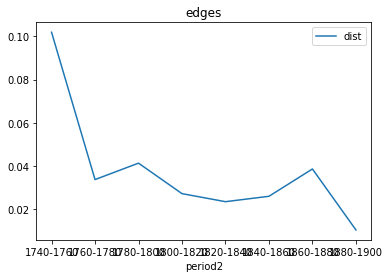

In [26]:
w=random.choice(list(novwords))
odf=speed_word(w,ybin=20)
odf.plot(x='period2',y='dist',kind='line',title=w)

In [24]:
nov('monday').query('p_peak<0.05')

foote_novelty  foote_size  p_peak  p_trough
word   period                                                
monday 1755-1760       2.148106           4    0.00       1.0
       1830-1835       1.748778           4    0.04       1.0
       1755-1760       3.516130           5    0.00       1.0
       1825-1830       2.795799           5    0.02       1.0
       1755-1760       4.256656           6    0.01       1.0
       1760-1765       4.065956           6    0.04       1.0